In [177]:
%matplotlib inline

## Import

In [178]:
import pandas as pd
import sklearn as sl
d = pd.read_csv('c:\\dev\\bike\\data\\hour.csv')

## Attribute Selection
Manual given the tiny set of attributes

### Remove

In [179]:
irrelevant_attributes = ['instant', # detached
                         'dteday', # mostly redundant
                         'holiday', # redundant
                         'casual', 'registered' # not in scope
                        ]
attributes = [a for a in d.columns if a not in irrelevant_attributes]

## Attribute Transformations
Considering the trade-offs between
 * loss of topology
 * inflation of dimension
 * Prevention of accidental information creation

### Indicators

In [180]:
one_hot_attributes = []#['season', 'weekday', 'mnth'] #loosing topology, moderate dimension inflation
data = pd.get_dummies(d[attributes],columns=one_hot_attributes)
print("Attributes after one hot inflation: ", len(list(data.columns.values)), "\n", list(data.columns.values))

Attributes after one hot inflation:  12 
 ['season', 'yr', 'mnth', 'hr', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']


### Cyclical

In [181]:
cycle_attributes = ['weekday', 'mnth']
import math
# 'hr' is cyclic, but the cut at 0:00 does not hurt
complex_trafo = lambda x, period : [sin(2*math.pi/period*x), cos(2*math.pi/period*x)]
cycle_preserving_transformation = {'weekday': lambda x: complex_trafo(x,7),
                                   'mnth': lambda x: complex_trafo(x,12)}

### Non-Linearities
Reflecting apparent non-linear impact. Render to standard normal distribution

In [182]:
 #log_attributes = ['weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'] #?

# Model
Rational:
1. Next best choice of linear model is probably not suitable because of univariate non-monotonicities

## Data

In [183]:
target = 'cnt'
features = [a for a in data.columns.values if a!=target]

X, Y = sl.utils.shuffle(data[features].values, data[target].values)
#lm_ridge = linear_model.Ridge(alpha= .3)
print('features', features)
print('dimension of model input X', X.shape, X.dtype)
print('dimension of model output Y', Y.shape, Y.dtype)

features ['season', 'yr', 'mnth', 'hr', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
dimension of model input X (17379, 11) float64
dimension of model output Y (17379,) int64


### Linear Model Ridge Regularisation

In [184]:
from sklearn import linear_model
lm_ridge = linear_model.RidgeCV(alphas =[0.01, 0.1, 10., 50., 100., 500., 1000.], cv=20)
lm_ridge.fit(X,Y)
print("alpha", lm_ridge.alpha_)

alpha 0.1


####  In-Sample Error

In [185]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
import numpy as np
lm_ridge_candidate = linear_model.Ridge(alpha = lm_ridge.alpha_)
lm_ridge_candidate.fit(X,Y)
Y_predicted = np.array([max(x, 0) for x in lm_ridge_candidate.predict(X)])
print('linear model candidate sum of coeffs', sum(abs(lm_ridge_candidate.coef_)),
      '\nmean', mean_absolute_error(Y_predicted, Y),
      '\nmedian', median_absolute_error(Y_predicted, Y))

linear model candidate sum of coeffs 671.7352182088563 
mean 104.38093231460428 
median 81.02464517306345


In [245]:
model_assessment(lm_ridge_candidate)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
 In sample errors
    mean 105.96040158795562 
    median 82.32528611349088
 Out of sample errors
    cv mean: 106.0404078324971 
    cv mean std  2.1133119551498116


106.0404078324971

#### Out-of-Sample Error

In [197]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lm_ridge_candidate, X, Y, cv=10,
                         scoring= 'neg_mean_absolute_error'
                         #'neg_mean_squared_error'
                        )
print('cv mean', abs(scores.mean()), 'cv std', scores.std())

cv mean 106.0404078324971 cv std 2.1133119551498116


## Gradient Boost Trees
To overcome shortcomings of the linear models

In [244]:
def model_assessment(model):
    print(model)
    model.fit(X,Y)
    Y_p = model.predict(X)
    print(' In sample errors\n    mean', mean_absolute_error(Y_p, Y),
          '\n    median', median_absolute_error(Y_p, Y))
    scores = cross_val_score(model, X, Y, cv=10, scoring= 'neg_mean_absolute_error')
    print(' Out of sample errors\n    cv mean:', abs(scores.mean()),
          '\n    cv mean std ', scores.std())
    return abs(scores.mean())   

In [218]:
# An manual search through the hyper-parameter space lead to the following settings: (GridSearchCV)
n_estimators= 150
max_depth = 7
treeBooster = sl.ensemble.GradientBoostingRegressor(n_estimators= n_estimators, max_depth = max_depth)
model_assement(treeBooster)

In sample errors
 mean 17.2443776611647 
 median 10.357995229695291
Out of sample errors
 cv mean: 23.9045304774899 
 std  0.8304861943273393


###  Desciption of the model candidate

mean error 22.82904522888623


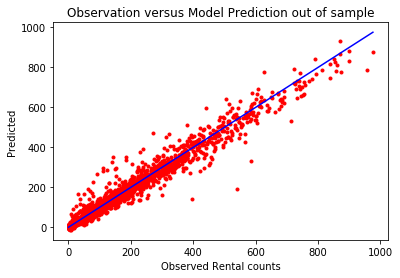

In [231]:
import matplotlib.pyplot as plt
n = round(.1 * len(Y))
X_train, Y_train, X_test, Y_test = X[n:], Y[n:], X[:n], Y[:n]
treeBooster_test = sl.ensemble.GradientBoostingRegressor(n_estimators= n_estimators, max_depth = max_depth)
treeBooster_test.fit(X_train, Y_train)
Y_predict_test = treeBooster_test.predict(X_test)
p = Y_test.argsort()
plt.plot(Y_test[p], Y_predict_test[p],'r.', Y_test[p], Y_test[p], 'b');
plt.title('Observation versus Model Prediction out of sample'); plt.xlabel('Observed Rental counts'); plt.ylabel('Predicted');
print("mean error", mean_absolute_error(Y_test, Y_predict_test))

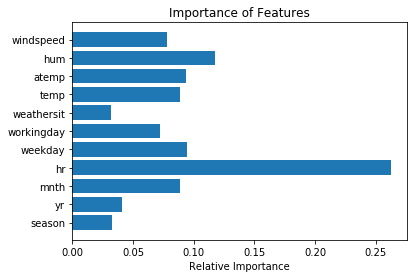

In [233]:
plt.barh(features, treeBooster.feature_importances_); plt.title('Importance of Features'); plt.xlabel('Relative Importance');

In [253]:
import graphviz
first_tree = treeBooster.estimators_[0,0]
dot_data = sl.tree.export_graphviz(first_tree, filled=True, rounded=True, proportion=True, out_file=None)
graph = graphviz.Source(dot_data)
graph.render('first tree')

'first tree.pdf'

In [257]:
from sklearn.neural_network import MLPRegressor
nn = MLPRegressor(hidden_layer_sizes=(30,10), max_iter=1000)
model_assessment(nn)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(30, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
 In sample errors
    mean 56.3485478775133 
    median 34.31989270110073
 Out of sample errors
    cv mean: 58.713353422363674 
    cv mean std  9.918831842725382


58.713353422363674

In [264]:
nn = sl.neighbors.KNeighborsRegressor(n_neighbors=30, weights='distance')
model_assessment(nn)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=30, p=2,
          weights='distance')
 In sample errors
    mean 0.012313711951205479 
    median 0.0
 Out of sample errors
    cv mean: 37.17356580485521 
    cv mean std  1.0493798111664137


37.17356580485521

In [267]:
from sklearn.kernel_ridge import KernelRidge
kr=KernelRidge(kernel='rbf')
model_assessment(kr)

KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='rbf',
      kernel_params=None)
 In sample errors
    mean 33.142217435588975 
    median 19.548329461903307
 Out of sample errors
    cv mean: 34.924247185774874 
    cv mean std  0.8281990492590274


34.924247185774874

In [269]:
np.mean(Y)

189.46308763450142